# Initialized Gradient Boosted Regression Trees

### Постановка ML задачи

##### Решаем задачу восстановления функции в общем контексте обучения с учителем.

##### У нас есть набор пар признаков $ x_i $ и целевых переменных $ y_i $ на котором мы будем восстанавливать зависимость вида $ y = f(x) $. 

##### Восстанавливать будем приближением $ \hat{f}(x) $.

##### Функция потерь $ L(y, f) = (y - f)^2 $, которую мы будем минимизировать:

# $ y \approx \hat{f}(x) $

# $ \hat{f}(x) = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf f(x)}} L(y, f(x)) $

# Представление

### Будем искать приближение $ \hat{f}(x) = \sum_{i=0}^T \hat{f}_i(x) $

# Индукция

##### Предположим, что у нас уже есть $ t-1 $ модель

##### Нужно построить модель под номером $ t $

# $ \hat{f}(x) = \sum_{i=0}^{t-1} \hat{f}_i(x) $

# $ (\rho_t, \theta_t) = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho,\theta}} 𝔼_{x,y}[L(y, \hat{f}_i(x) + \rho*h(x, \theta)] $

# $ \hat{f}_t(x) = \rho_t*h(x, \theta_t) $

# А теперь к практическому поиску параметров

# $ \hat{f}(x) = \sum_{i=0}^{t-1} \hat{f}_i(x) $

# $ r_{it} = -{\left[ \frac{dL(y_i, f(x_i))}{df(x_i)} \right]}_{f(x)=\hat{f}(x)} i=1..n$

# $ \theta_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \theta}} \sum_{i=1}^{n} (r_{it} - h (x_i, \theta))^2 $

# $ \rho_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho}} \sum_{i=1}^{n} L(y_i, \hat{f}(x_i) + \rho*h(x_i, \theta_t)) $

# Посмотрим, что мы имеем

### 1) Обучающая выборка $ \{(x_i, y_i)\}_{i=1..n} $

### 2) Число моделей T

### 3) Функция потерь - квадратичная $ L(y, f) = (y - f)^2 $

### 4) Базовый алгоритм - рещающее дерево

### 5) Гиперпараметры базового алгоритма

# Алгоритм

##### 1) Инициализировать GBM RandomForest/ом (?)

##### 2) Для каждой итерации t=1..T:

##### 2.1) Посчитать $ r_{it} = -{\left[ \frac{dL(y_i, f(x_i))}{df(x_i)} \right]}_{f(x)=\hat{f}(x)} i=1..n $

##### 2.2) Построить новый базовый алгоритм  $ h_t(x) $ как регрессию на псевдо-остатках $ \{(x_i, r_{it})\}_{i=1..n} $

##### 2.3) Найти оптимальный коэффициент  $ \rho_t $ при $ h_t(x) $ относительно исходной функции потерь
##### $ \rho_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho}} \sum_{i=1}^{n} L(y_i, \hat{f}(x_i) + \rho*h(x_i, \theta)) $

##### 2.4) Сохранить  $ \hat{f}_t(x) = \rho_t*h(x) $

##### 2.5) Обновить текущее приближение $ \hat{f}(x) $ 
##### $ \hat{f}(x) = \sum_{i=0}^{t} \hat{f}_i(x) $ 

##### 3) Получить итоговую модель $ \hat{f}(x) = \sum_{i=0}^{T} \hat{f}_i(x) $

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [209]:
# Класс модель с константым предсказаем
class ConstModel:
    def __init__(self, value: float):
        self.value = value
        
    def fit(X, y):
        pass
    
    def predict(self, X) -> np.array:
        return np.array([self.value]*len(X))

In [226]:
class GBRT:
    def __init__(self, depth: int, T: int):
        self.depth = depth
        self.T = T
        self.models = []
        self.k = []
    
    @staticmethod
    def L(y_right: np.array, y_pred: np.array) -> float:
        return ((y_right - y_pred)**2).sum()
    
    @staticmethod
    def dL(y_right: np.array, y_pred: np.array) -> np.array:
        return 2*(y_right - y_pred)
        
    # TODO Поиск коэффициента можно улучшить
    # 1) Бинарный поиск
    # 2) "Умный" поиск (?)
    def __searchBestRo(self, y_right: np.array, y_pred: np.array, new_predict: np.array) -> float:
        search_range = np.arange(-1.0, 1.0, 0.1)
        bufer = np.zeros(shape=len(search_range))
        for i, x in enumerate(search_range):
            bufer[i] = self.L(y_right, y_pred + x*new_predict)
        
        return search_range[np.argmin(bufer)]
    
    def __searchBestFirstRo(self, y_right: np.array, new_predict: np.array) -> float:
        search_range = np.arange(-1.0, 1.0, 0.1)
        bufer = np.zeros(shape=len(search_range))
        for i, x in enumerate(search_range):
            bufer[i] = self.L(y_right, x*new_predict)
        
        return search_range[np.argmin(bufer)]
            
    
    def fit(self, X, y):
        # Инициализация первой моделью
        first_model = ConstModel(2)        
        first_predict = first_model.predict(X)
        ro = self.__searchBestFirstRo(y, first_predict)
        
        self.models.append(first_model)
        self.k.append(ro)
        
        for t in range(1, self.T):
            y_pred = self.predict(X)
            r = self.dL(y, y_pred)
            # Создаем новую модель и учим ее на  псевдо-остатках
            new_model = DecisionTreeRegressor(max_depth=self.depth)
            new_model.fit(X, r)
            new_predict = new_model.predict(X)
            # Находим оптимальный коэффициент для новой модели
            ro = self.__searchBestRo(y, y_pred, new_predict)
            # Добавляем модель и ее коэффициент
            self.models.append(new_model)
            self.k.append(ro)
    
    def predict(self, X, last=None) -> np.array:
        answer = np.zeros(shape=len(X))
        if last is None:
            for i, model in enumerate(self.models):
                answer += self.k[i] * model.predict(X)
        else:
            for i, model in enumerate(self.models[:last]):
                answer += self.k[i] * model.predict(X)
        return answer

# Тестирование

In [265]:
y_right = np.array([0.0]*10)
y_pred = np.array([1.0]*10)
assert GBRT.L(y_right, y_pred) == 10.0

# Создание тестового датасета $ y = sin(x)*cos(x) $

In [309]:
X = np.arange(-5, 5, 0.03)
y = np.sin(X) * np.cos(X)

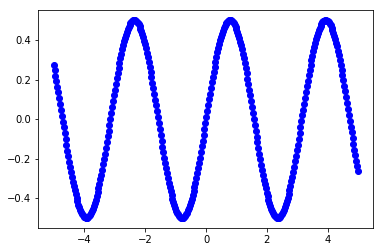

In [310]:
plt.plot(X, y, 'bo')

##### Добавим шума

In [311]:
y += np.random.normal(0.0, 0.1, size=len(X))

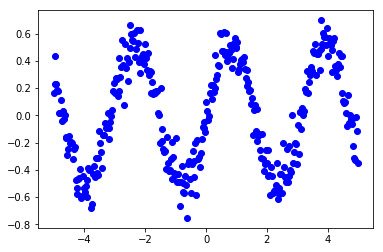

In [313]:
plt.plot(X, y, 'bo')

# Тестирование модели

In [329]:
T = 10
depth = 3

In [330]:
model = GBRT(depth, T)

In [334]:
# Потому что одна фича
X = X.reshape(-1, 1)

In [335]:
model.fit(X, y)

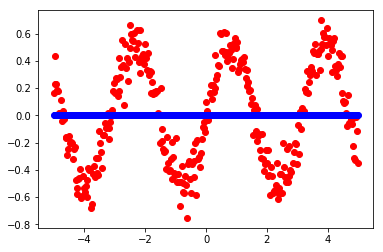

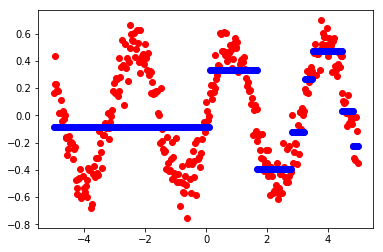

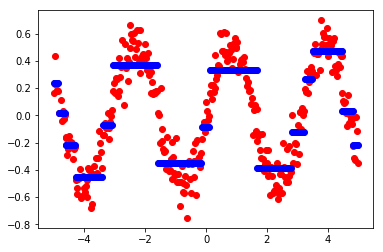

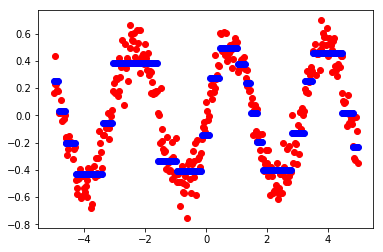

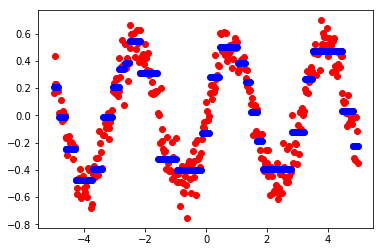

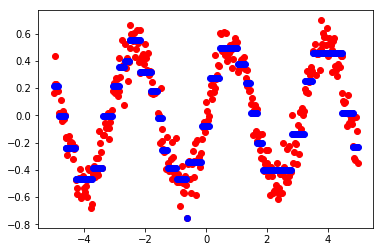

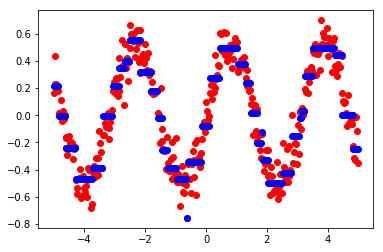

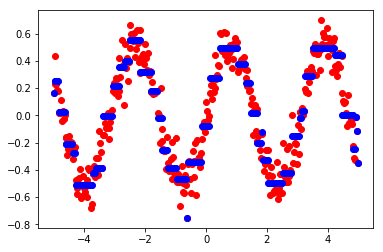

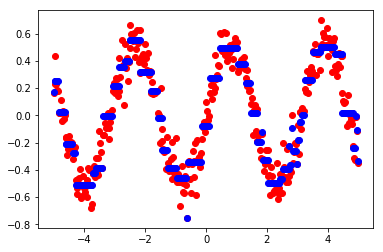

In [336]:
for i in range(1,T):
    fig, ax = plt.subplots()
    y_pred = model.predict(X, i)
    ax.plot(X, y, 'bo', color='red')
    ax.plot(X, y_pred, 'bo')